# Application for Data Science Intern - Summer 2022 (Remote, US & Canada)

**Applicant: Guanxiong Shao**

## Prompt ##
    On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

## Question & Responses ##

*a.	Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.*

    There are 17 very large orders come from shop 42 with user 607. And all of these orders are of the same order amount and total items. This may have different implications including the user 607 has a special contract with shop 42, user 607 is artificially bumping shop 42's sales, or else. 

    There are also samples with very large unit price (`order_amount / total_items`)For the samples with very large unit price, they all come from shop 78 but with 46 different users. Thus, it's less likely that 46 people are colluding with the store to artifically bump up the price of the item. Nonetheless, it is still highly unlikely that multiple orders of this magnitude are traded for sneakers. Potential reasons include an erroreous store tag, issue with currency, or else. 

    Since we are now aware of the outlier issue, a better metric to report the average order value should remove the outliers' effect on average or instead use median. 


*b.	What metric would you report for this dataset?*

    Thus I propose the below metrics: 1) average order size using only orders within two standard deviation of the 97.5th percentile of the sample population and 2) box plot.

(Please see below)

*c.	What is its value?*

    The modified average order size without taking outliers into account is: 293.81


Change directory path

In [1]:
import os

os.chdir("C:/Users/sgxjs/Downloads")
cwd = os.getcwd()
print(cwd)

C:\Users\sgxjs\Downloads


Import data and show basic summary statistics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("./Shopify_Dataset.csv")
display(df.describe())
display(df.info())
df.head()


,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


None

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


Check for missing values

In [3]:
for i in range(df.shape[1]):
    print(f'Column {df.columns[i]} has {pd.isnull(df.iloc[:,i]).sum()} null values')

Column order_id has 0 null values
Column shop_id has 0 null values
Column user_id has 0 null values
Column order_amount has 0 null values
Column total_items has 0 null values
Column payment_method has 0 null values
Column created_at has 0 null values


Based on the summary statistics, some orders seem to have very large order_amount and total_items.

Visualize order_amount vs total_items and look for outliers

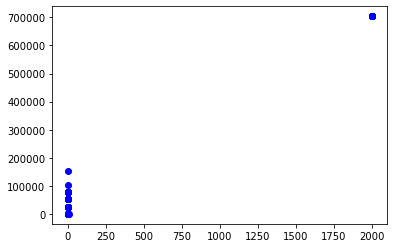

In [4]:
plt.plot(df.total_items, df.order_amount, 'bo', )

Text(0.5, 1.0, 'Unit Price without Outliers')

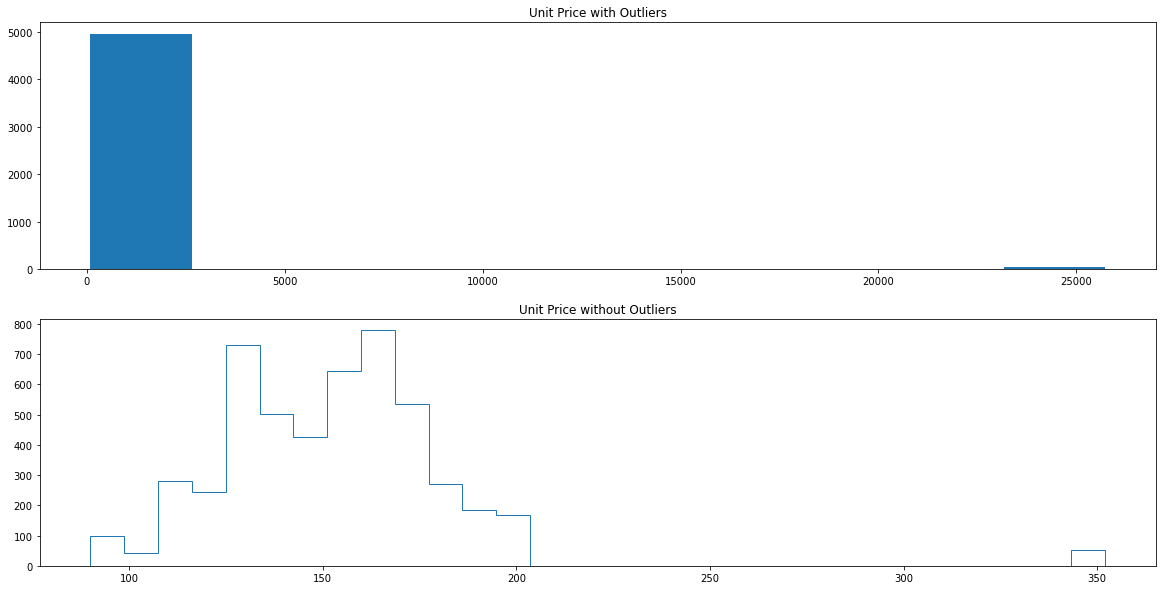

In [5]:
df2 = pd.concat([df, pd.DataFrame(df.order_amount / df.total_items, columns=["avg"])], axis=1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,10))

ax1.hist(df2.avg)
ax1.set_title("Unit Price with Outliers")
ax2.hist(df2.loc[df2.avg < 10000].avg, histtype="step", bins=30)
ax2.set_title("Unit Price without Outliers")

Unexpected pattern: 

Most samples are aggreated around the left while one or several samples are all located at the upper right. The upper right samples could potentially be outliers that don't represent the overall sneaker shop community, thus causing the unusually large average order size.

Item prices are mostly aggregated on the left (below 400) while several samples have very large unit price. These items with over 10,000 unit price likely don't represent sneakers. So it's a good idea to exclude them from average order size calculation.

Filter for the large orders for further analysis

In [6]:
large_orders = df.loc[(df.total_items >= 2000)]
display(large_orders.describe())
large_orders.drop(["order_id", "created_at"], axis=1).value_counts()

,order_id,shop_id,user_id,order_amount,total_items
count,17.000000,17.0,17.0,17.0,17.0
mean,2336.235294,42.0,607.0,704000.0,2000.0
std,1603.584872,0.0,0.0,0.0,0.0
min,16.000000,42.0,607.0,704000.0,2000.0
25%,1363.000000,42.0,607.0,704000.0,2000.0
50%,2154.000000,42.0,607.0,704000.0,2000.0
75%,3333.000000,42.0,607.0,704000.0,2000.0
max,4883.000000,42.0,607.0,704000.0,2000.0


shop_id  user_id  order_amount  total_items  payment_method
42       607      704000        2000         credit_card       17
dtype: int64

In [7]:
large_unit_price = df2.loc[df2.avg > 10000]
display(large_unit_price.describe())
large_unit_price.groupby("shop_id").agg("count")

,order_id,shop_id,user_id,order_amount,total_items,avg
count,46.000000,46.0,46.000000,46.000000,46.000000,46.0
mean,2663.021739,78.0,867.739130,49213.043478,1.913043,25725.0
std,1338.520020,0.0,81.314871,26472.227449,1.029047,0.0
min,161.000000,78.0,707.000000,25725.000000,1.000000,25725.0
25%,1428.250000,78.0,812.500000,25725.000000,1.000000,25725.0
50%,2796.500000,78.0,866.500000,51450.000000,2.000000,25725.0
75%,3720.250000,78.0,935.750000,51450.000000,2.000000,25725.0
max,4919.000000,78.0,997.000000,154350.000000,6.000000,25725.0


,order_id,user_id,order_amount,total_items,payment_method,created_at,avg
shop_id,,,,,,,
78,46,46,46,46,46,46,46


All 17 of the large orders come from shop 42 with user 607. And all of these orders are of the same order amount and total items. This may have different implications including the user 607 has a special contract with shop 42, user 607 is artificially bumping shop 42's sales, or else. 

For the samples with very large unit price, they all come from shop 78 but with 46 different users. Thus, it's less likely that 46 people are colluding with the store to artifically bump up the price of the item. Nonetheless, it is still highly unlikely that multiple orders of this magnitude are traded for sneakers. Potential reasons include an erroreous store tag, issue with currency, or else. 

Since we are now aware of the outlier issue, a better metric to report the average order value should remove the outliers' effect on average or instead use median. 

Thus I propose the below metrics: 1) average order size using only orders within two standard deviation of the 97.5th percentile of the sample population and 2) box plot

In [8]:
def avg_order_size_without_outlier(df):
    """The function filters the dataset for a subset of samples whose order_amount is 
    lower than the 97.5 percentile of the population. Then it calculates the mean and 
    standard deviation of the subset. Function returns the subset of samples 
    whose order_amount is below three standard deviation above the mean"""
    
    df_0to975 = df.loc[df.order_amount <= df.quantile(.975).order_amount,:]
    std_0to975 = df_0to975.order_amount.std()
    mean_0to975 = df_0to975.order_amount.mean()

    three_std_above = mean_0to975 + 3 * std_0to975

    mod_df = df.loc[(df.order_amount < three_std_above)]
    
    return mod_df

Calculate the modified average order size

In [12]:
modified_df = avg_order_size_without_outlier(df)
mod_avg_order = modified_df.order_amount.mean()

print(f'The modified average order size without taking outliers \
into account is: {mod_avg_order:5.2f}')

The modified average order size without taking outliers into account is: 293.81


{'whiskers': [<matplotlib.lines.Line2D at 0x1f8fa417df0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f8fa4264f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f8fa417a90>],
 'medians': [<matplotlib.lines.Line2D at 0x1f8fa426bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f8fa426f10>],
 'means': []}

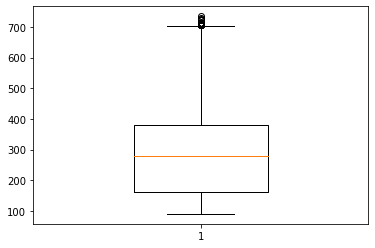

In [10]:
plt.boxplot(modified_df.order_amount, widths=0.4, meanline=True)